In [13]:
import track
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
# Vanilla = SGD with momentum.
# LRD = learning rate dropout using original masking code (use uniform cdf)
# Bernoulli = use torch bernoulli code from the official paper implementation
# Official = using official optimizer class outright (instead of just changing mask code)

# These results use four random seeds for each configuration.

proj = track.Project("./remote_logs/logs", None)  # None = remote url
vanilla_ids = proj.ids[proj.ids['lr_dropout_rate'] == 1.0]['trial_id']
lrd_ids = proj.ids[proj.ids['lr_dropout_rate'] == 0.5]['trial_id']

vanilla = proj.results(vanilla_ids)
lrd = proj.results(lrd_ids)

# Using paper masking
bernoulli_proj = track.Project("./remote_bernoulli_logs/bernoulli_logs/bernoulli_tests", None)
bernoulli_ids = bernoulli_proj.ids['trial_id']
bernoulli = bernoulli_proj.results(bernoulli_ids)

# Using optimizer from paper code
official_proj = track.Project("./remote_official_logs/official_logs/official_tests", None)
official_ids = official_proj.ids['trial_id']
official = official_proj.results(official_ids)

In [43]:
### Average accuracy over all seeds
def seed_avg(df, col, ids):
    #return df[df['trial_id'].isin(ids)].groupby(['trial_id'])[col].mean()
    return df.groupby(['iteration']).mean()[col]

vanilla_test_accs = seed_avg(vanilla, 'test_acc', vanilla_ids)
vanilla_train_accs = seed_avg(vanilla, 'train_acc', vanilla_ids)
lrd_test_accs = seed_avg(lrd, 'test_acc', lrd_ids)
lrd_train_accs = seed_avg(lrd, 'train_acc', lrd_ids)

bernoulli_test_accs = seed_avg(bernoulli, 'test_acc', bernoulli_ids)
bernoulli_train_accs = seed_avg(bernoulli, 'train_acc', bernoulli_ids)

official_test_accs = seed_avg(official, 'test_acc', official_ids)
official_train_accs = seed_avg(official, 'train_acc', official_ids)

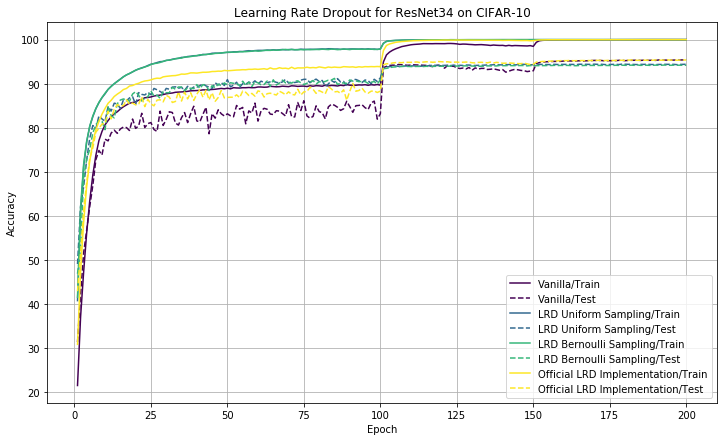

In [44]:
### Plotting
x = list(range(1, 201))

markersize = 12

plt.figure(figsize=(12, 7))

n_dfs = 4
color = iter(plt.cm.viridis(np.linspace(0, 1, n_dfs)))

## vanilla
c = next(color)
plt.plot(x, vanilla_train_accs, label='Vanilla/Train', color=c, markersize=markersize)
plt.plot(x, vanilla_test_accs, label='Vanilla/Test', color=c, linestyle='dashed', markersize=markersize)
## learning rate dropout (uniform CDF code)
c = next(color)
plt.plot(x, lrd_train_accs, label='LRD Uniform Sampling/Train', color=c, markersize=markersize)
plt.plot(x, lrd_test_accs, label='LRD Uniform Sampling/Test', color=c, linestyle='dashed', markersize=markersize)
# bernoulli sampling code
c = next(color)
plt.plot(x, bernoulli_train_accs, label='LRD Bernoulli Sampling/Train', color=c, markersize=markersize)
plt.plot(x, bernoulli_test_accs, label='LRD Bernoulli Sampling/Test', color=c, linestyle='dashed', markersize=markersize)

# using the optimizer from the official repo
c = next(color)
plt.plot(x, official_train_accs, label='Official LRD Implementation/Train', color=c, markersize=markersize)
plt.plot(x, official_test_accs, label='Official LRD Implementation/Test', color=c, linestyle='dashed', markersize=markersize)

# plt
plt.title('Learning Rate Dropout for ResNet34 on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [51]:
# Max of averages
print("Maximum accuracy of averaged per-trial curves")
print("Vanilla avg test max acc: %.4f" % vanilla_test_accs.max())
print("LRD (uniform sampling) avg test max acc: %.4f" % lrd_test_accs.max())
print("LRD (torch bernoulli sampling) avg test max acc: %.4f" % bernoulli_test_accs.max())
print("Official LRD implementation avg test max acc: %.4f" % official_test_accs.max())

Maximum accuracy of averaged per-trial curves
Vanilla avg test max acc: 95.4500
LRD (uniform sampling) avg test max acc: 94.4250
LRD (torch bernoulli sampling) avg test max acc: 94.2500
Official LRD implementation avg test max acc: 95.3850


In [52]:
def avg_of_maxes(df):
    return df.groupby(['trial_id'])['best_acc'].max()
vanilla_max_accs = avg_of_maxes(vanilla)
lrd_max_accs = avg_of_maxes(lrd)
bernoulli_max_accs = avg_of_maxes(bernoulli)
official_max_accs = avg_of_maxes(official)

# Now, average of maxes. This 
print("Averages of per-trial max accuracy")
print("Vanilla test max acc avg: %.4f (std=%.4f)" % (vanilla_max_accs.max(), vanilla_max_accs.std()))
print("LRD (uniform sampling) test max avg: %.4f (std=%.4f)" % (lrd_max_accs.max(), lrd_max_accs.std()))
print("LRD (torch bernoulli sampling) test max acc avg: %.4f (std=%.4f)" % (bernoulli_max_accs.max(), bernoulli_max_accs.std()))
print("Official LRD implementation test max acc avg: %.4f (std=%.4f)" % (official_max_accs.max(), official_max_accs.std()))


Averages of per-trial max accuracy
Vanilla test max acc avg: 95.5700 (std=0.0693)
LRD (uniform sampling) test max avg: 94.5100 (std=0.2174)
LRD (torch bernoulli sampling) test max acc avg: 94.3600 (std=0.0835)
Official LRD implementation test max acc avg: 95.6400 (std=0.2208)
